In [12]:
import os
import sys
import json
import re
import random
import numpy as np
import pandas as pd

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, 
    Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, class_weight
from sklearn.preprocessing import MinMaxScaler

In [13]:
# Used for relabeling disengagements with label 5 with the label of the disengagement occurring beforehand
# Reason - label 5 - 'bad engagement' is very likely caused by the same reason the disenagegement beforehand occured
last_label = -1

In [14]:
# Function to create window sample from a dataframe containing one disegnagement's logs
def process_windows(window):
    global last_label

    # Extracting important values from the logs, like:
    # window start time
    # window end time
    # labelling it as transition
    # boolean for unplanned or unplanned (for possible analysis)
    # Label for disengagement reason
    start_time = window.index[0]
    end_time = window.index[-1]
    label = 'transition'
    planned_unplanned_label = (
                    'planned' if (window['disengagement_type'] == 1).any() 
                    else 'unplanned'
                )
    reason_label = window.loc[window['disengagement_reason'] != -1, 'disengagement_reason'].iloc[0]

    # Replacing label 5 with the previous disengagement's label
    if reason_label == 5:
        reason_label = last_label

    last_label = reason_label

    columns_to_remove = [
        'drivemode', 'tm', 'disengagement', 'disengagement_type', 
        'planned_unplanned', 'steeringmode', 'datum_id', 'disengagement_reason'
    ]
    window = window.drop(columns=columns_to_remove, errors='ignore')

    summary_df = pd.DataFrame([{
        'window_start': start_time,
        'window_end': end_time,
        'label': label,
        'planned_unplanned_label': planned_unplanned_label,
        'reason_label': reason_label
    }])

    # Add the dataframe (containing logs) to field 'data'
    summary_df['data'] = [window]
    
    return summary_df
    

In [15]:
# Initialize the lists to store windows in train (all_windows) and test (test_windows) sets
windows = []
all_windows = []
test_windows = []

# Dictionary to track which labels are already selected for the test set
selected_labels = {i: False for i in range(9)}
# Dictionary to track the occurrences of labels
label_occurrences = {i: 0 for i in range(9)}

# Test set selection strategy based on label occurrences
test_set_thresholds = {
    0: 1,
    1: 1,
    2: 1,
    3: 3, 
    4: 2,
    6: 2
}

base_folder = 'F:\\Processed_CSVs'

# Iterating over each ride's folder in the base_folder and over each separate disengagement CSV file
for folder in os.listdir(base_folder):
    folder_path = os.path.join(base_folder, folder)
    for file in os.listdir(folder_path):
        # As folders contain some helper files starting with prefix 'processed', we do not want to look at them as they are not disenagement files
        # This is due to my filetree structure
        if file.startswith('processed'):
            continue
        
        file_path = os.path.join(folder_path, file)
        
        try:
            # Read and preprocess the CSV files of disengagements
            df = pd.read_csv(file_path)
            df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
            df.set_index('Time', inplace=True)
            df.sort_index(inplace=True)

            # Process the disengagement window
            window_data = process_windows(df)
            label = window_data['reason_label'].iloc[0]
            window = window_data['data'].iloc[0]

            # Tracking occurrences
            label_occurrences[label] += 1

            # Adding the window either to test or train set
            # Goal is to have one test smaple of each class from the original disnagement files
            if (
                label in test_set_thresholds and 
                label_occurrences[label] == test_set_thresholds[label] and 
                not selected_labels[label]
            ):
                test_windows.append(window_data)
                selected_labels[label] = True
            else:
                windows.append(window)
                all_windows.append(window_data)

            print(f"Processed file: {file} | Label: {label} ")
        
        except Exception as e:
            print(f"Error processing {file_path}: {e}")


Processed file: 2023-10-16-10-14-49_tiksoja_ride_02_sfa_with_disengagements_disengagement_1.csv | Label: 0.0 
Processed file: 2023-10-16-10-14-49_tiksoja_ride_02_sfa_with_disengagements_disengagement_2.csv | Label: 0.0 
Processed file: 2023-10-16-10-30-17_tiksoja_ride_03_cluster_with_disengagements_disengagement_1.csv | Label: 0.0 
Processed file: 2023-10-16-10-30-17_tiksoja_ride_03_cluster_with_disengagements_disengagement_2.csv | Label: 1.0 
Processed file: 2023-10-16-10-30-17_tiksoja_ride_03_cluster_with_disengagements_disengagement_3.csv | Label: 1.0 
Processed file: 2023-10-16-10-30-17_tiksoja_ride_03_cluster_with_disengagements_disengagement_4.csv | Label: 1.0 
Processed file: 2023-10-16-10-30-17_tiksoja_ride_03_cluster_with_disengagements_disengagement_5.csv | Label: 1.0 
Processed file: 2023-10-16-10-30-17_tiksoja_ride_03_cluster_with_disengagements_disengagement_6.csv | Label: 0.0 
Processed file: 2023-10-16-10-50-24_tiksoja_ride_04_sfa_with_disengagements_disengagement_1.csv 

In [16]:
scaler = MinMaxScaler()
# Function to normalize data to fit between 0 and 1
def normalize_window(window, scaler):
    scaled_window = pd.DataFrame(
        scaler.fit_transform(window),
        columns=window.columns,
        index=window.index
    )
    return scaled_window

In [17]:
# Combining a list of dataframes into one dataframe for train set
all_windows_df = pd.concat(all_windows, ignore_index=True)

In [18]:
all_windows_df.shape

(154, 6)

In [19]:
all_windows_df

,window_start,window_end,label,planned_unplanned_label,reason_label,data
0,2023-10-16 07:23:16.276942848,2023-10-16 07:23:21.268647680,transition,unplanned,0.0,steer_cmd.steer...
1,2023-10-16 07:31:56.326267392,2023-10-16 07:32:01.324991744,transition,unplanned,0.0,steer_cmd.steer...
2,2023-10-16 07:37:25.504470272,2023-10-16 07:37:30.489510400,transition,unplanned,1.0,steer_cmd.steer...
3,2023-10-16 07:38:46.796892672,2023-10-16 07:38:51.796723456,transition,unplanned,1.0,steer_cmd.steer...
4,2023-10-16 07:38:59.442547712,2023-10-16 07:39:04.440316928,transition,unplanned,1.0,steer_cmd.steer...
...,...,...,...,...,...,...
149,2023-11-03 12:08:37.331823616,2023-11-03 12:08:42.325234432,transition,planned,6.0,steer_cmd.steer...
150,2023-11-03 12:13:08.995402496,2023-11-03 12:13:13.995218432,transition,planned,6.0,steer_cmd.steer...
151,2023-11-03 12:13:21.233490432,2023-11-03 12:13:26.223711488,transition,planned,6.0,steer_cmd.steer...
152,2023-11-03 12:14:09.129708288,2023-11-03 12:14:14.121680896,transition,planned,3.0,steer_cmd.steer...


In [20]:
# Combining a list of dataframes into one dataframe for test set
test_windows_df = pd.concat(test_windows, ignore_index=True)

In [21]:
# Normalize data for train set
all_windows_df['data'] = all_windows_df['data'].apply(lambda x: normalize_window(x, scaler))

In [22]:
# Normalize data for test set
test_windows_df['data'] = test_windows_df['data'].apply(lambda x: normalize_window(x, scaler))

In [23]:
# Calculating the number of samples from each label group
windows_by_label = all_windows_df.groupby('reason_label')
class_counts = all_windows_df['reason_label'].value_counts()
print(f"Class distribution before augmentation:\n{class_counts}")
# Number of samples we would like to have after augmenting the data
target_class_count = int(class_counts.max()*5)
print(target_class_count)

Class distribution before augmentation:
reason_label
0.0    64
1.0    29
3.0    23
2.0    13
4.0    12
6.0    11
7.0     1
8.0     1
Name: count, dtype: int64
320


In [24]:
# Calculating the number of samples from each label group
test_windows_by_label = test_windows_df.groupby('reason_label')
test_class_counts = test_windows_df['reason_label'].value_counts()
print(f"Class distribution before augmentation:\n{test_class_counts}")
# Number of samples we would like to have after augmenting the data
test_target_class_count = int(test_class_counts.max()*5)
print(test_target_class_count)

Class distribution before augmentation:
reason_label
0.0    1
1.0    1
2.0    1
3.0    1
4.0    1
6.0    1
Name: count, dtype: int64
5


In [25]:
def scale_numeric_values(data, scale_range=(0.95, 1.05)):
    augmented_data = data.copy()
    
    # Selecting numeric columns
    numeric_columns = augmented_data.select_dtypes(include=[np.number]).columns

    # Choosing a random value/percentage from the scale range to scale the data in order to create slightly di
    scaling_factor = np.random.uniform(scale_range[0], scale_range[1])
    # Apply scaling, ignoring values of -999
    for col in numeric_columns:
        augmented_data[col] = augmented_data[col].apply(
            lambda x: x * scaling_factor if x != -999 else x
        )
    
    return augmented_data


In [26]:
augmented_windows = []

# Iterate over each reason_label group
for label, group in windows_by_label:
    current_count = len(group)
    num_to_generate = max(0, target_class_count - current_count)
    
    print(f"Augmenting {label}: {current_count} -> {target_class_count} (Generating {num_to_generate})")
    
    # Add all original windows for this label
    augmented_windows.extend(group.to_dict(orient='records'))
    
    # Generate augmented samples
    for _ in range(num_to_generate):
        # Randomly select an original row from the group
        row = group.sample(n=1).iloc[0]
        
        # Extract the data and augment it
        original_data = row['data']  # Extract the `data` DataFrame
        augmented_data = scale_numeric_values(original_data)  # Apply scaling
        
        # Create an augmented version of the row
        augmented_row = {
            'window_start': row['window_start'],
            'window_end': row['window_end'],
            'label': row['label'],
            'planned_unplanned_label': row['planned_unplanned_label'],
            'reason_label': label,
            'data': augmented_data
        }
        
        # Add the augmented row to the list
        augmented_windows.append(augmented_row)

# Create a new DataFrame with augmented windows
augmented_windows_df = pd.DataFrame(augmented_windows)


Augmenting 0.0: 64 -> 320 (Generating 256)
Augmenting 1.0: 29 -> 320 (Generating 291)
Augmenting 2.0: 13 -> 320 (Generating 307)
Augmenting 3.0: 23 -> 320 (Generating 297)
Augmenting 4.0: 12 -> 320 (Generating 308)
Augmenting 6.0: 11 -> 320 (Generating 309)
Augmenting 7.0: 1 -> 320 (Generating 319)
Augmenting 8.0: 1 -> 320 (Generating 319)


In [27]:
test_augmented_windows = []

# Iterate over each reason_label group
for label, group in test_windows_by_label:
    current_count = len(group)
    num_to_generate = max(0, test_target_class_count - current_count)
    
    print(f"Augmenting {label}: {current_count} -> {test_target_class_count} (Generating {num_to_generate})")
    
    # Add all original windows for this label
    test_augmented_windows.extend(group.to_dict(orient='records'))
    
    # Generate augmented samples
    for _ in range(num_to_generate):
        # Randomly select an original row from the group
        row = group.sample(n=1).iloc[0]
        
        # Extract the data and augment it
        original_data = row['data']  # Extract the `data` DataFrame
        augmented_data = scale_numeric_values(original_data)  #Apply scaling
        
        # Create an augmented version of the row
        augmented_row = {
            'window_start': row['window_start'],
            'window_end': row['window_end'],
            'label': row['label'],
            'planned_unplanned_label': row['planned_unplanned_label'],
            'reason_label': label,
            'data': augmented_data
        }
        
        # Add the augmented row to the list
        test_augmented_windows.append(augmented_row)

# Create a new DataFrame with augmented windows
test_augmented_windows_df = pd.DataFrame(test_augmented_windows)


Augmenting 0.0: 1 -> 5 (Generating 4)
Augmenting 1.0: 1 -> 5 (Generating 4)
Augmenting 2.0: 1 -> 5 (Generating 4)
Augmenting 3.0: 1 -> 5 (Generating 4)
Augmenting 4.0: 1 -> 5 (Generating 4)
Augmenting 6.0: 1 -> 5 (Generating 4)


In [28]:
max_rows = max(row['data'].shape[0] for _, row in augmented_windows_df.iterrows())
print(max_rows)

1304


In [29]:
def pad_or_truncate_window(window, fixed_rows):
    """
    Adjust window to have a fixed number of rows.
    If the window has fewer rows, pad with zeros. If more, truncate to `fixed_rows`.
    """
    n_features = window.shape[1]  # Number of features per row
    if window.shape[0] < fixed_rows:  # Padding
        padding = np.zeros((fixed_rows - window.shape[0], n_features))
        return np.vstack((window, padding))
    elif window.shape[0] > fixed_rows:  # Truncation
        return window[:fixed_rows, :]
    return window  # Already the correct shape

In [ ]:
class_id = 1  # Label the following model is trained for (range from 0 to 8)
model_save_path = "F:\\models"  # Directory to save the model

# Creating directory if needed
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

# Filtering out data for the selected class (1 for the selected class, 0 for all others)
print(f"Processing class {class_id}...")
class_data = augmented_windows_df.copy()
class_data['binary_label'] = (class_data['reason_label'] == class_id).astype(int)

# Separating the data for label 0 and label 1
class_0_data = class_data[class_data['binary_label'] == 0]
class_1_data = class_data[class_data['binary_label'] == 1]

# Downsampling the majority class in order to have equal number of samples for both classes
class_0_downsampled = resample(class_0_data, 
                               replace=False, 
                               n_samples=len(class_1_data), 
                               random_state=42)

# Combining the balanced data
balanced_data = pd.concat([class_0_downsampled, class_1_data])

# Prepare features (X) and labels (y)
X = []
y = []

for _, row in balanced_data.iterrows():
    window_data = row['data']

    # Padding or truncating the window to have a fixed number of rows
    adjusted_window = pad_or_truncate_window(window_data, max_rows)

    # Appending the window and label to the lists
    X.append(adjusted_window)
    y.append(row['binary_label'])

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Splitting into train and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train set shape: {X_train.shape}")


# Compute class weights for imbalanced classes (even though we balanced them)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(256, 3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(512, 3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(2),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compiling
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping which stops training if the validation loss does not improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Training
print(f"Training model for class {class_id}...")
model.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=100, 
          batch_size=8,
          class_weight=class_weights_dict,
          callbacks=[early_stopping],
          verbose=1)

# Saving
model_file = os.path.join(model_save_path, f"model_class_{class_id}_new.h5")
model.save(model_file)
print(f"Model for class {class_id} saved at {model_file}.")


Processing class 1...
Train set shape: (512, 1304, 484)


'\n# Compute class weights for imbalanced classes (even though we balanced them)\nclass_weights = compute_class_weight(class_weight=\'balanced\', classes=np.unique(y), y=y)\nclass_weights_dict = {i: weight for i, weight in enumerate(class_weights)}\n\n# Model\nmodel = Sequential([\n    Input(shape=(X_train.shape[1], X_train.shape[2])),\n    Conv1D(128, 3, activation=\'relu\', kernel_regularizer=l2(0.01)),\n    BatchNormalization(),\n    MaxPooling1D(2),\n    Conv1D(256, 3, activation=\'relu\', kernel_regularizer=l2(0.01)),\n    BatchNormalization(),\n    MaxPooling1D(2),\n    Conv1D(512, 3, activation=\'relu\', kernel_regularizer=l2(0.01)),\n    BatchNormalization(),\n    MaxPooling1D(2),\n    GlobalAveragePooling1D(),\n    Dense(128, activation=\'relu\'),\n    Dropout(0.3),\n    Dense(1, activation=\'sigmoid\')\n])\n\n# Compiling\noptimizer = Adam(learning_rate=0.0001)\nmodel.compile(optimizer=optimizer, loss=\'binary_crossentropy\', metrics=[\'accuracy\'])\n\n# Early stopping which s

In [30]:
# Paths to the saved models
model_save_path = "F:\\models"
model_paths = {
    0: os.path.join(model_save_path, "model_class_0_new.h5"),
    1: os.path.join(model_save_path, "model_class_1_new.h5"),
    2: os.path.join(model_save_path, "model_class_2_new.h5"),
    3: os.path.join(model_save_path, "model_class_3_new.h5"),
    4: os.path.join(model_save_path, "model_class_4_new.h5"),
    6: os.path.join(model_save_path, "model_class_6_new.h5"),
    7: os.path.join(model_save_path, "model_class_7_new.h5"),
    8: os.path.join(model_save_path, "model_class_8_new.h5")
}

# Dictionary to store the loaded models
models = {class_id: load_model(path) for class_id, path in model_paths.items()}

In [31]:
# Custom thresholds for each class (default is 0.5, but can be adjusted if needed)
thresholds = {
    0: 0.5,
    1: 0.5,
    2: 0.5,
    3: 0.5,
    4: 0.5,
    6: 0.5,
    7: 0.5,
    8: 0.5
}


In [25]:
!pip install shap

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 23.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   ----- ---------------------------------- 3.9/30.3 MB 19.6 MB/s eta 0:00:02
   -------------- ------------------------- 10.7/30.3 MB 24.9 MB/s eta 0:00:01
   --------------------- ------------------ 16.5/30.3 MB 26.0 MB/s eta 0:00:01
   -------------------------------- ------- 24.4/30.3 MB 28.6 MB/s eta 0:00:01
   ---------------------------------------  30.1/30.3 MB 29.0 MB/s eta 0:00:01
   ---------------------------------------- 30.3/30.3 MB 27.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
X_test = []
for _, row in test_augmented_windows_df.iterrows():
    window_data = row['data']

    # Padding or truncating the window to have a fixed number of rows
    adjusted_window = pad_or_truncate_window(window_data, max_rows)

    # Appending the window to the list
    X_test.append(adjusted_window)

X_test = np.array(X_test)

In [34]:
predictions = []

for class_id, model in models.items():
    # Probability predictions
    y_pred_prob = model.predict(X_test)
    
    # Apply the threshold for this class which is stored in the `thresholds` dictionary
    y_pred_binary = (y_pred_prob > thresholds[class_id]).astype(int)
    
    # Store the predictions
    predictions.append({
        'class_id': class_id,
        'probabilities': y_pred_prob.flatten(),
        'binary_predictions': y_pred_binary.flatten()
    })


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


In [35]:
final_labels = []

for i in range(len(X_test)):
    # Tracking which models predict 1
    predicting_classes = [
        pred['class_id'] for pred in predictions if pred['binary_predictions'][i] == 1
    ]
    
    # If only one model predicts 1, we use that label
    if len(predicting_classes) == 1:
        final_labels.append(predicting_classes[0])
    # If multiple models predict 1, we label it as 'uncertain'
    elif len(predicting_classes) > 1:
        final_labels.append('uncertain')
    # If no model predicts 1, we label it as 'undetermined'
    else:
        final_labels.append('undetermined')


In [36]:
# Adding the final labels to the DataFrame
test_augmented_windows_df['final_label'] = final_labels

# Adding the probabilities to the DataFrame
for pred in predictions:
    class_id = pred['class_id']
    test_augmented_windows_df[f'prob_class_{class_id}'] = pred['probabilities'].round(6)


In [43]:
# Definign the columns to display for analysis
columns_to_display = [
    'reason_label', # Original label
    'final_label', # Predicted label
]

# Adding the proabilities of each class to the columns to display
for class_id in model_paths.keys():
    columns_to_display.append(f'prob_class_{class_id}')

print(test_augmented_windows_df[columns_to_display])


    reason_label  final_label  prob_class_0  prob_class_1  prob_class_2  \
0            0.0            0      0.687938      0.003520      0.000026   
1            0.0            0      0.715870      0.004323      0.000029   
2            0.0            0      0.741498      0.005325      0.000032   
3            0.0            0      0.745476      0.005505      0.000033   
4            0.0            0      0.787226      0.007885      0.000040   
5            1.0            1      0.000019      0.823055      0.000005   
6            1.0            1      0.000050      0.868594      0.000007   
7            1.0            1      0.000029      0.843321      0.000006   
8            1.0            1      0.000040      0.859563      0.000007   
9            1.0            1      0.000013      0.802793      0.000004   
10           2.0            2      0.000007      0.000027      0.998200   
11           2.0            2      0.000012      0.000030      0.998083   
12           2.0         

In [58]:
# Create a dictionary to store SHAP values
shap_values_dict = {}

import shap

# Define the masker
#masker = shap.maskers.Independent(X_test)

# Initialize SHAP explainers with the masker
shap_explainers = {
    class_id: shap.DeepExplainer(model, X_test)
    for class_id, model in models.items()
}


for class_id, explainer in shap_explainers.items():
    shap_values = explainer(X_test)
    shap_values_dict[class_id] = shap_values




c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_layer. Received: the structure of inputs=['*']
  warnings.warn(
c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_layer_13. Received: the structure of inputs=['*']
  warnings.

In [59]:
feature_names = test_augmented_windows_df['data'].iloc[0].columns

In [60]:
shap_values.shape

(30, 1304, 484, 1)

In [61]:
import pandas as pd
import numpy as np

# Define the classes to analyze
classes_to_analyze = [0, 1, 2, 3, 4, 6]

# Dictionary to store top 10 features for each class
shap_top_features_per_class = {}

# Loop over each class
for class_id in classes_to_analyze:
    # Ensure SHAP values for the class are available
    if class_id in shap_values_dict:
        shap_values = shap_values_dict[class_id].values
        shap_values = np.squeeze(shap_values)  # Remove unnecessary last dimension
        
        # Boolean mask for correctly classified samples
        correct_classifications = test_augmented_windows_df[
            (test_augmented_windows_df["reason_label"] == class_id) &
            (test_augmented_windows_df["final_label"] == class_id)
        ].index

        filtered_shap_values = shap_values[correct_classifications]
        
        if filtered_shap_values.shape[0] == 0:
            print(f"No correctly classified samples for class {class_id}.")
            continue
        
        print(f"SHAP values shape for class {class_id} after filtering: {filtered_shap_values.shape}")
        
        # Aggregate SHAP values across time steps (rows per sample)
        aggregated_shap_values = np.mean(filtered_shap_values, axis=1)
        
        # Convert to DataFrame for easier processing
        shap_df = pd.DataFrame(aggregated_shap_values, columns=feature_names)
        
        # Compute mean SHAP values only over correctly classified samples
        mean_shap_values = shap_df.mean(axis=0)
        
        # Get the top 10 absolute contributing features
        top_10_features = mean_shap_values.sort_values(ascending=False).head(10).round(6)
        
        # Get the top 10 negatively contributing features
        top_10_negative_features = mean_shap_values.sort_values().head(10).round(6)
        
        # Store results in dictionary
        shap_top_features_per_class[class_id] = {
            "top_10_positive_contributors": top_10_features,
            "top_10_negative_contributors": top_10_negative_features
        }
        
        # Save results to files
        with open(f"shap_top_10_positive_features_class_{class_id}.txt", "w") as file:
            file.write(f"Top 10 features with mean SHAP values for class {class_id} (correctly classified samples):\n")
            for feature, value in top_10_features.items():
                file.write(f"{feature} - {value}\n")
        
        with open(f"shap_top_10_negative_features_class_{class_id}.txt", "w") as file:
            file.write(f"Top 10 negatively contributing features for class {class_id} (correctly classified samples):\n")
            for feature, value in top_10_negative_features.items():
                file.write(f"{feature} - {value}\n")
        
        print(f"Top 10 features and negative contributors for class {class_id} saved.")
    else:
        print(f"Class ID {class_id} not found in SHAP values!")

# Now, shap_top_features_per_class contains both the top positive and negative features per class for further visualization


SHAP values shape for class 0 after filtering: (5, 1304, 484)
Top 10 features and negative contributors for class 0 saved.
SHAP values shape for class 1 after filtering: (5, 1304, 484)
Top 10 features and negative contributors for class 1 saved.
SHAP values shape for class 2 after filtering: (5, 1304, 484)
Top 10 features and negative contributors for class 2 saved.
SHAP values shape for class 3 after filtering: (5, 1304, 484)
Top 10 features and negative contributors for class 3 saved.
SHAP values shape for class 4 after filtering: (5, 1304, 484)
Top 10 features and negative contributors for class 4 saved.
SHAP values shape for class 6 after filtering: (5, 1304, 484)
Top 10 features and negative contributors for class 6 saved.


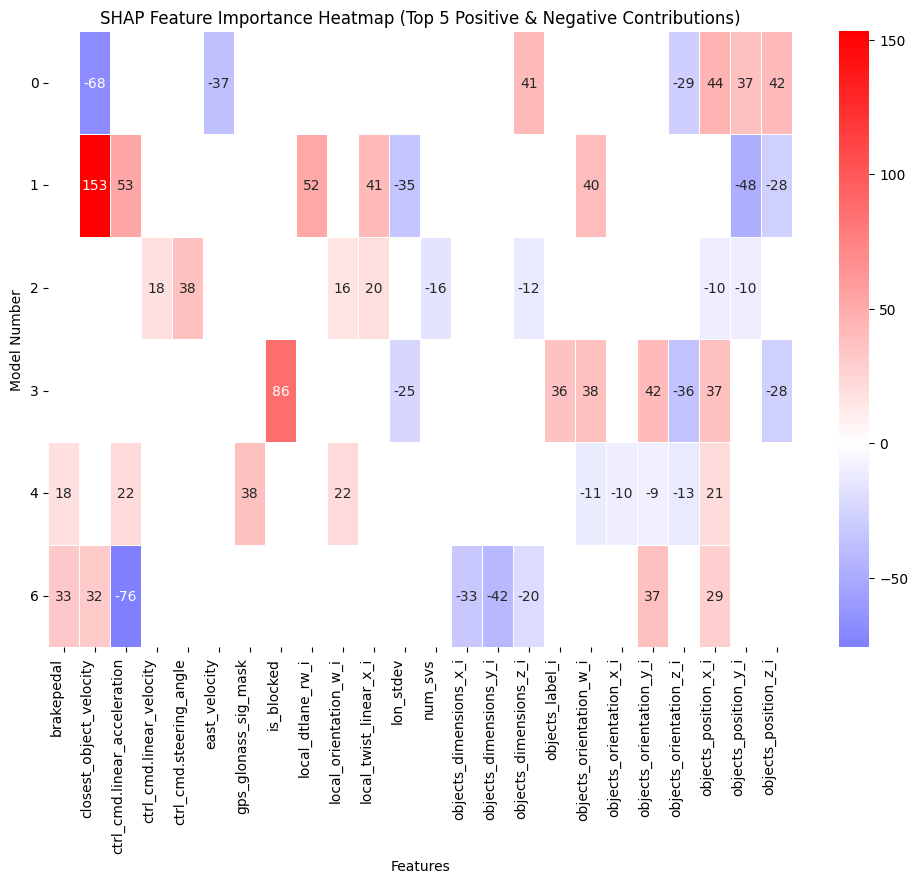

c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


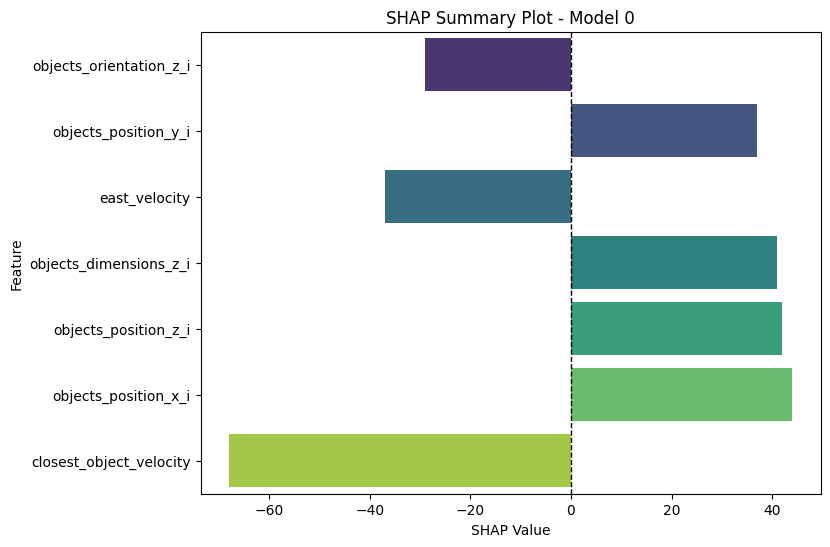

c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


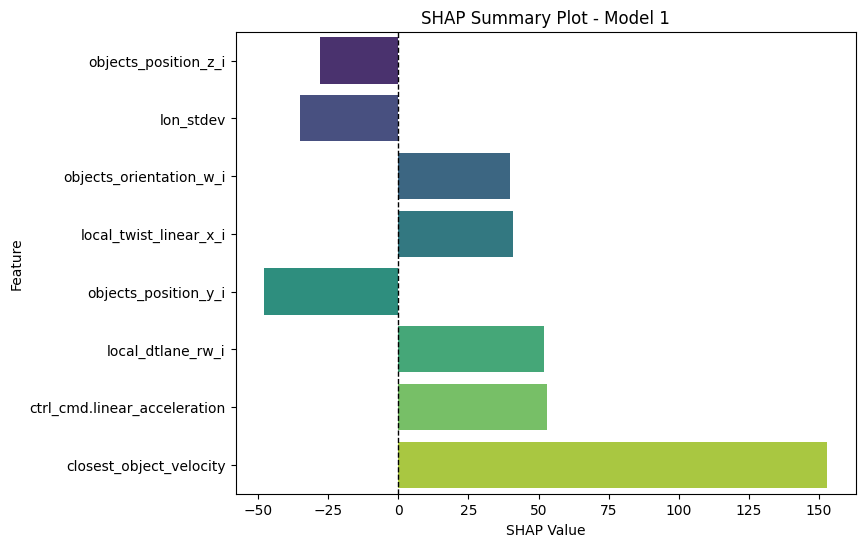

c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


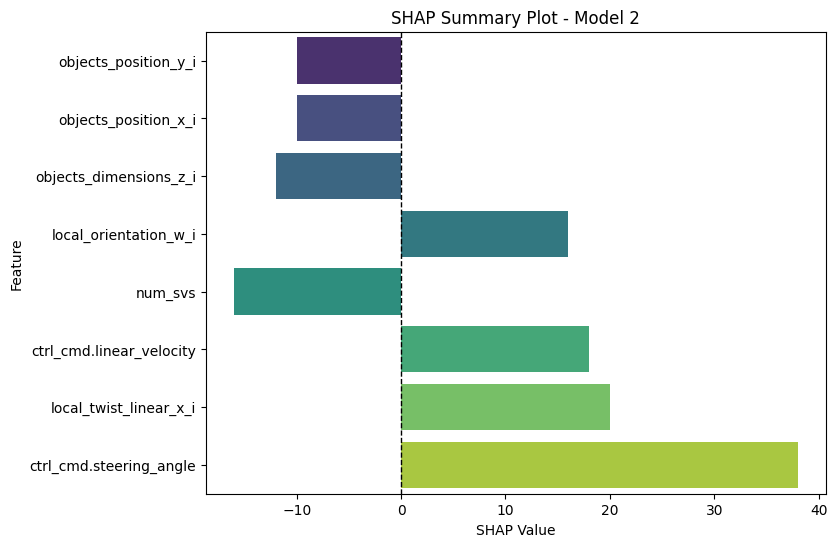

c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


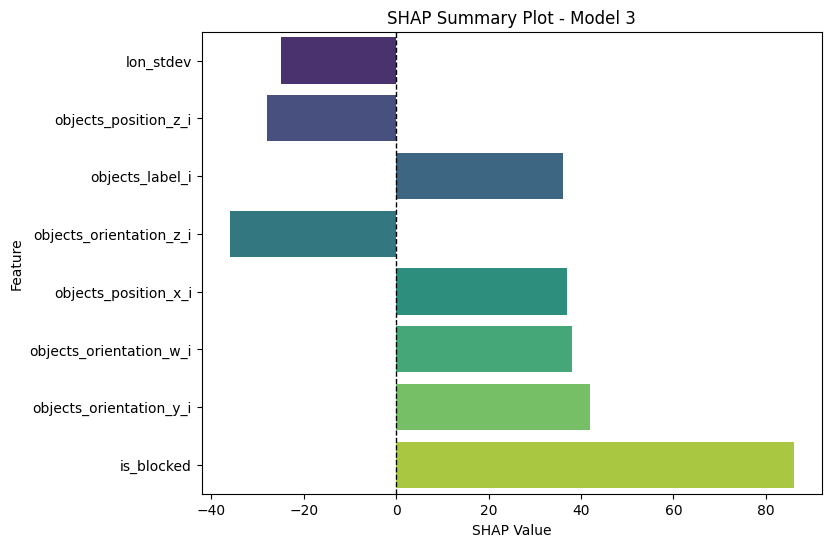

c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


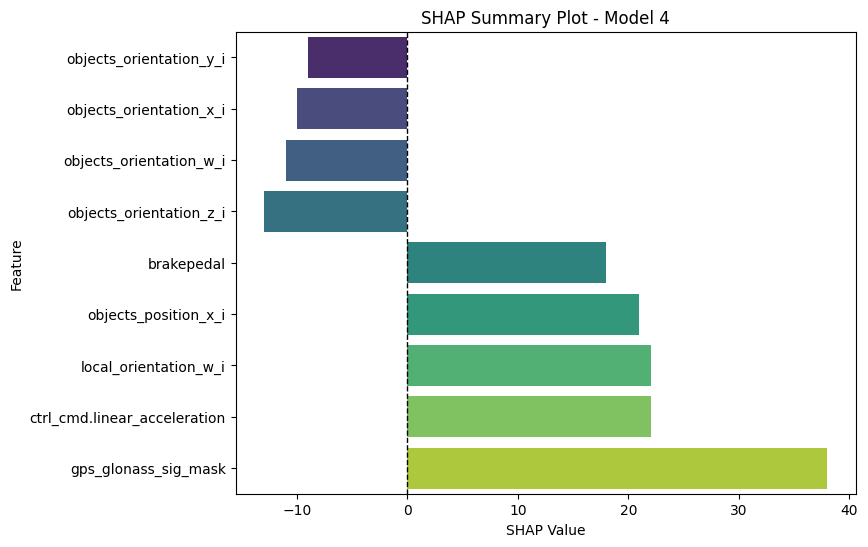

c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elisabeh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


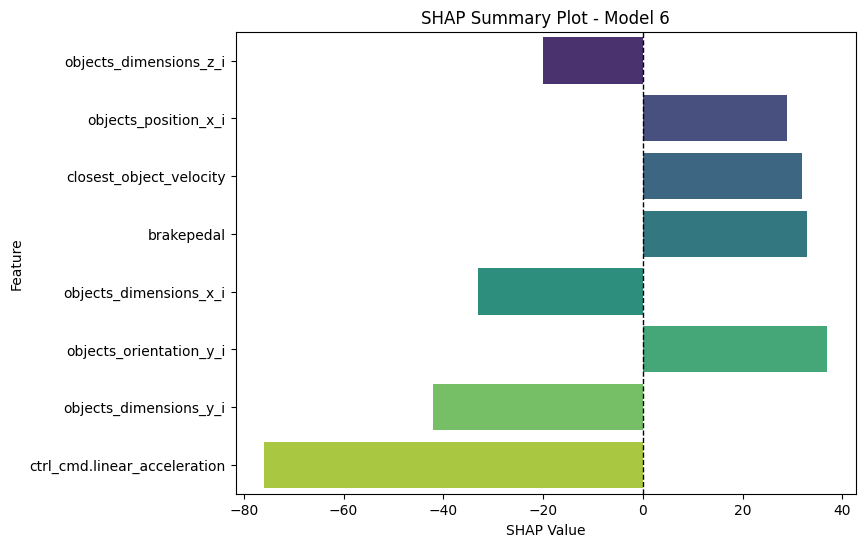

In [62]:
import os
import glob
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Get all SHAP text files in the current directory
positive_files = glob.glob("shap_top_10_positive_features_class_*.txt")
negative_files = glob.glob("shap_top_10_negative_features_class_*.txt")

# Dictionary to store SHAP values (both positive and negative)
shap_data = {}

# Function to process SHAP files (only read top 5 items)
def process_shap_files(files, shap_data):
    for file in files:
        # Extract class_id (model number) from filename
        match = re.search(r"class_(\d+)", file)
        if not match:
            continue  # Skip files without a valid class_id
        class_id = int(match.group(1))

        # Read the file content
        with open(file, "r") as f:
            lines = f.readlines()

        # Process SHAP feature lines (skip header, limit to 5)
        if class_id not in shap_data:
            shap_data[class_id] = {}

        for i, line in enumerate(lines[1:]):  # Skip header, limit to 5
            if i >= 5:
                break  # Stop after reading 5 features

            parts = line.strip().split(" - ")
            if len(parts) != 2:
                continue

            feature, value = parts[0], float(parts[1])

            # Normalize feature name by replacing numerical suffixes with _i
            feature = re.sub(r"_\d+$", "_i", feature)

            # Store only the first occurrence of a feature
            if feature not in shap_data[class_id]:
                shap_data[class_id][feature] = value * 1_000_000  # Scale values

# Process positive and negative SHAP files (only 5 features per class)
process_shap_files(positive_files, shap_data)
process_shap_files(negative_files, shap_data)

# Convert to DataFrame
df = pd.DataFrame.from_dict(shap_data, orient='index').fillna(0)
df.index.name = "Model Number"
df.columns.name = "Feature"

df.sort_index(inplace=True)
df = df.reindex(sorted(df.columns), axis=1)

# Define custom colormap: blue for negative, red for positive
colors = ["blue", "white", "red"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=256)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    df,
    cmap=custom_cmap,
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    cbar=True,
    center=0,
    vmin=df.min().min(),
    vmax=df.max().max(),
    mask=(df == 0)
)
plt.title("SHAP Feature Importance Heatmap (Top 5 Positive & Negative Contributions)")
plt.xlabel("Features")
plt.ylabel("Model Number")
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)
plt.savefig("shap_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()



for model_id, feature_values in shap_data.items():
    plt.figure(figsize=(8, 6))
    
    # Convert to DataFrame for easy plotting
    feature_df = pd.DataFrame(feature_values.items(), columns=["Feature", "SHAP Value"])
    
    # Sort by absolute SHAP value (importance)
    feature_df["Abs SHAP Value"] = feature_df["SHAP Value"].abs()
    feature_df = feature_df.sort_values("Abs SHAP Value", ascending=True)
    
    # Plot bar chart
    sns.barplot(
        data=feature_df,
        x="SHAP Value",
        y="Feature",
        palette="viridis"
    )
    
    plt.axvline(0, color="black", linestyle="--", linewidth=1)  # Add vertical line at 0
    plt.title(f"SHAP Summary Plot - Model {model_id}")
    plt.xlabel("SHAP Value")
    plt.ylabel("Feature")
    plt.show()